In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use('bmh')
 
import ta

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

df = pd.read_csv('data/SPY5yr.csv')

In [11]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-18,202.770004,202.929993,199.830002,200.020004,181.605713,251393500
1,2015-12-21,201.410004,201.880005,200.089996,201.669998,183.103790,99094300
2,2015-12-22,202.720001,203.850006,201.550003,203.500000,184.765350,111026200
3,2015-12-23,204.690002,206.070007,204.580002,206.020004,187.053391,110987200
4,2015-12-24,205.720001,206.330002,205.419998,205.679993,186.744629,48539600


In [12]:
## Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)



## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
df = df.tail(1000)



## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df.head()

C:\Users\jbogg\anaconda3\lib\site-packages\ta\trend.py:643: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
C:\Users\jbogg\anaconda3\lib\site-packages\ta\trend.py:647: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


,Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-29,-1.311550,-1.468610,-1.557566,-0.354703,-0.344718,0.158288,-0.438955,-0.393692,-0.717169,-0.609382,...,-1.500888,-0.037708,-1.335560,-0.692622,-0.953862,-0.356100,-1.611962,-0.108888,-0.109008,-1.311550
2016-12-30,-1.331179,-1.478568,-1.661965,-0.328167,-0.516824,-0.246020,-0.254065,-0.485944,-0.575841,-0.609382,...,-1.435619,-0.109885,-1.338935,-1.054752,-0.512874,-0.422893,-0.424481,-0.504161,-0.505583,-1.331179
2017-01-03,-1.290245,-1.464724,-1.574454,-0.214909,-0.121114,-0.269888,0.286925,-0.416455,0.188052,-0.601651,...,-0.755857,-0.163305,-1.338850,-0.494572,-0.332742,-0.431872,0.024995,0.797767,0.795518,-1.290245
2017-01-04,-1.258169,-1.443521,-1.499033,-0.113922,0.105890,-0.341533,0.227454,-0.403826,1.120970,-0.595592,...,-0.192571,-0.208297,-1.337951,-0.429819,-0.302145,-0.431504,0.097664,0.601896,0.600706,-1.258169
2017-01-05,-1.262478,-1.423289,-1.574104,-0.122951,0.035887,-0.208396,-0.109139,-0.344940,0.301737,-0.596406,...,-0.142530,-0.226429,-1.337778,-0.178629,-0.275968,-0.424749,0.147317,-0.174726,-0.174969,-1.262478


In [13]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)
  
  
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          
          
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [14]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [15]:
## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 90, 90)            63000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 30)            14520     
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
Total params: 101,190
Trainable params: 101,190
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 193ms/step - loss: 0.2730 - accuracy: 0.0164 - val_loss: 1.7285 - val_accuracy: 0.0112
Epoch 2/50
7/7 [==============================] - 1s 112ms/step - loss: 0.1640 - accuracy: 0.0240 - val_lo

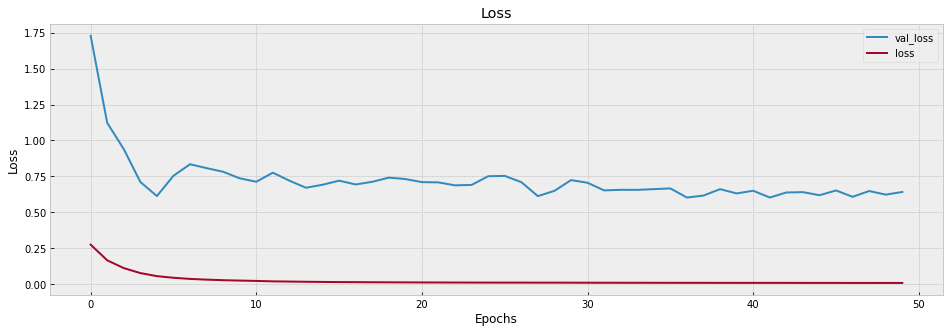

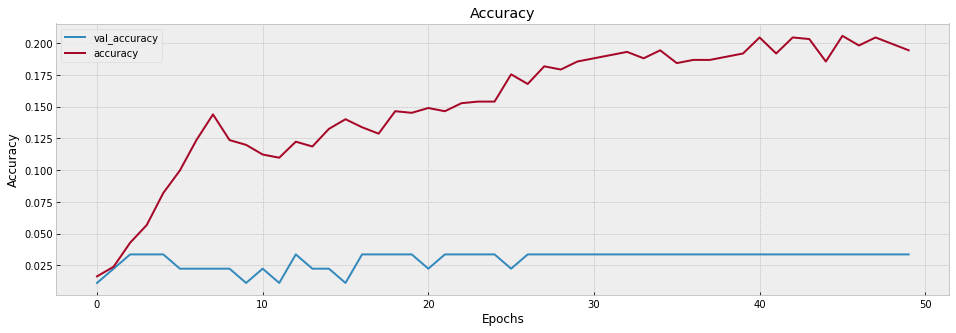

In [16]:
visualize_training_results(res)

RMSE: 4.695451621291207


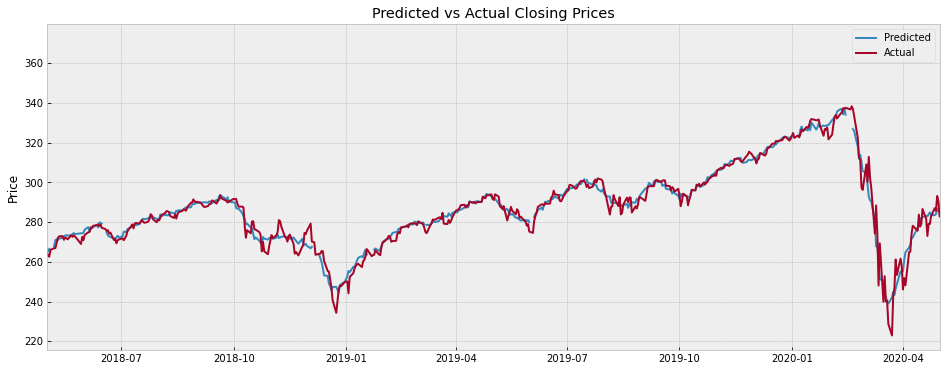

In [17]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2018-05', '2020-05')
plt.show()

                 Close
2020-12-18  317.942139
2020-12-21  314.560150
2020-12-22  307.761230
2020-12-23  306.513733
2020-12-24  302.852142
2020-12-25  291.134277
2020-12-28  287.194489
2020-12-29  280.846710
2020-12-30  282.068573
2020-12-31  274.300842
2021-01-01  269.991699
2021-01-04  259.483185
2021-01-05  252.446152
2021-01-06  257.773956
2021-01-07  257.515686
2021-01-08  250.475922
2021-01-11  257.073151
2021-01-12  246.375504
2021-01-13  258.796906
2021-01-14  246.428650
2021-01-15  255.237305
2021-01-18  265.154694
2021-01-19  258.041321
2021-01-20  265.528473
2021-01-21  265.401459
2021-01-22  263.116180
2021-01-25  269.497192
2021-01-26  268.617828
2021-01-27  278.525635
2021-01-28  279.935089


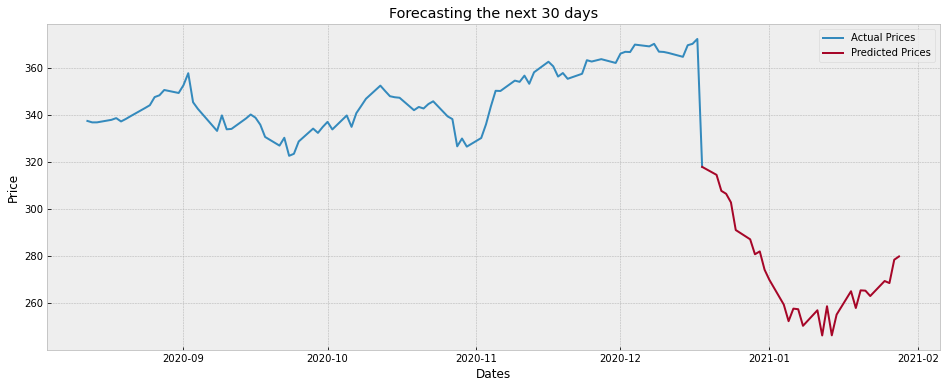

In [18]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()

In [ ]:
## Every time through, predicts SPY falling off a cliff in the next 30 days. Is there an issue in the code? ##
## OR is a large correction that overdue? ##